In [28]:
%matplotlib inline
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import skimage.segmentation

# Load a single image and its associated masks
id = 'af576e8ec3a8d0b57eb6a311299e9e4fd2047970d3dd9d6f52e54ea6a91109da'
file = "../input/stage1_train/{}/images/{}.png".format(id,id)
mfile = "../input/stage1_train/{}/masks/*.png".format(id)
print(mfile)
image = skimage.io.imread(file)
masks = skimage.io.imread_collection(mfile).concatenate()
# print(masks)
height, width, _ = image.shape
# num_masks = masks.shape[0]

../input/stage1_train/af576e8ec3a8d0b57eb6a311299e9e4fd2047970d3dd9d6f52e54ea6a91109da/masks/*.png


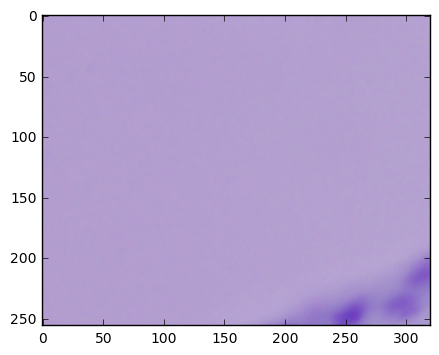

In [17]:
plt.imshow(image)

In [29]:
# Make a ground truth array and summary label image
y_true = np.zeros((num_masks, height, width), np.uint16)
y_true[:,:,:] = masks[:,:,:] // 255  # Change ground truth mask to zeros and ones

ValueError: could not broadcast input array from shape (2,256,320) into shape (27,256,320)

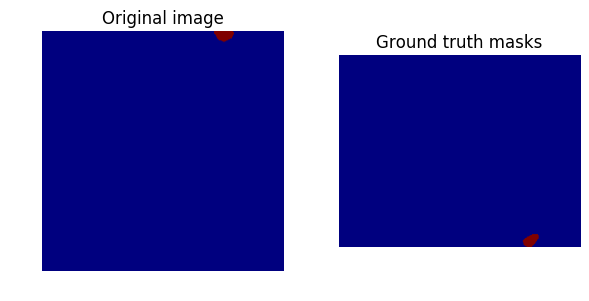

In [26]:
# Show label image
fig, axes = plt.subplots(1,2, figsize=(6,4))
axes[0].imshow(y_true[0])
axes[0].set_title("Original image")
axes[1].imshow(masks[0])
axes[1].set_title("Ground truth masks")
plt.tight_layout()
for ax in axes:
    ax.axis('off')

In [4]:
labels = np.zeros((height, width), np.uint16)
labels[:,:] = np.sum(y_true, axis=0) 

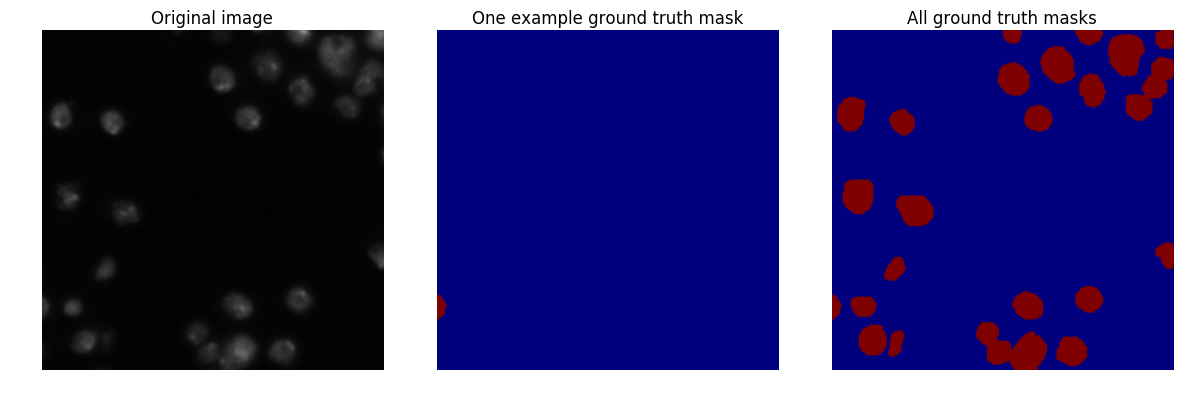

In [5]:
# Show label image
fig, axes = plt.subplots(1,3, figsize=(12,4))
axes[0].imshow(image)
axes[0].set_title("Original image")
axes[1].imshow(y_true[3])
axes[1].set_title("One example ground truth mask")
axes[2].imshow(labels)
axes[2].set_title("All ground truth masks")
plt.tight_layout()
for ax in axes:
    ax.axis('off')

In [6]:
# Simulate an imperfect submission
offset = 2 # offset pixels
y_pr1 = y_true[:19, offset:, offset:]  # To remove 'item 20' as per other kernel
y_pr2 = y_true[20:, offset:, offset:]
y_pred = np.concatenate((y_pr1, y_pr2), axis=0)
y_pred = np.pad(y_pred, ((0,0), (0, offset), (0, offset)), mode="constant")
#y_pred[y_pred == 20] = 0 # Remove one object
#y_pred, _, _ = skimage.segmentation.relabel_sequential(y_pred) # Relabel objects
yptot = np.sum(y_pred, axis=0)  # Sum individual predictions for plotting


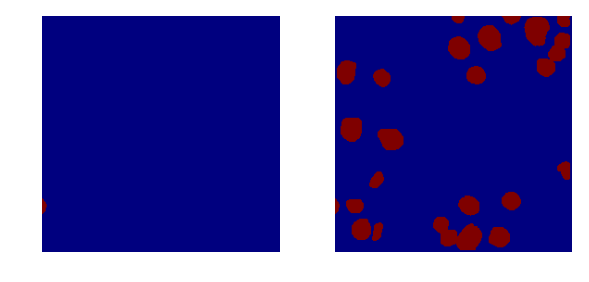

In [7]:
fig, axes = plt.subplots(1,2, figsize=(6,4))
axes[0].imshow(y_pred[3])
axes[0].set_title("")
axes[1].imshow(yptot)
axes[1].set_title("")
plt.tight_layout()
for ax in axes:
    ax.axis('off')

In [8]:
y_true.shape

(27, 256, 256)

In [9]:
# Compute number of objects
num_true = len(y_true)
num_pred = len(y_pred)
print("Number of true objects:", num_true)
print("Number of predicted objects:", num_pred)


Number of true objects: 27
Number of predicted objects: 26


In [10]:
# Compute iou score for each prediction
iou = []
for pr in range(num_pred):
    bol = 0  # best overlap
    bun = 1e-9  # corresponding best union
    for tr in range(num_true):
        # from IPython.core.debugger import Tracer; Tracer()()
        olap = y_pred[pr] * y_true[tr]  # Intersection points
        osz = np.sum(olap)  # Add the intersection points to see size of overlap
        if osz > bol:  # Choose the match with the biggest overlap
            bol = osz
            bun = np.sum(np.maximum(y_pred[pr], y_true[tr]))  # Union formed with sum of maxima
    iou.append(bol / bun)

In [11]:
# Loop over IoU thresholds
p = 0
print("Thresh\tTP\tFP\tFN\tPrec.")
for t in np.arange(0.5, 1.0, 0.05):
    matches = iou > t
    tp = np.count_nonzero(matches)  # True positives
    # from IPython.core.debugger import Tracer; Tracer()()
    fp = num_pred - tp  # False positives
    fn = num_true - tp  # False negatives
    p += tp / (tp + fp + fn)
    print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))

print("AP\t-\t-\t-\t{:1.3f}".format(p / 10))


Thresh	TP	FP	FN	Prec.
0.500	25	1	2	0.893
0.550	24	2	3	1.720
0.600	22	4	5	2.430
0.650	18	8	9	2.944
0.700	13	13	14	3.269
0.750	4	22	23	3.351
0.800	0	26	27	3.351
0.850	0	26	27	3.351
0.900	0	26	27	3.351
0.950	0	26	27	3.351
AP	-	-	-	0.335
